# Model Pipeline

By: Aditya Mengani, Ognjen Sosa, Sanjay Elangovan, Song Park, Sophia Skowronski

**Can we improve on the baseline scores using different encoding, imputing, and scaling schemes?**
- Averaged Logistic Regression accuracy Score: 0.5
- Averaged Linear Regression accuracy score: 0.2045
- Averaged K-Nearest Neighbour accuracy score: 0.6198
- Averaged Naive Bayes accuracy score: 0.649

**`p1_tag` ~  `rank` + `total_funding_usd` + `employee_count` (ordinal) + `country` (nominal) + `category_groups` (nominal)**

### STEPS FOR CONNECTING TO COLAB

https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/

*  Upload the .csv files to your google drive
*  Go to the file in google drive, right click on file name, then click on 'Get Link' and it shows the unique id of the file. Copy it and save it in the below code:
downloaded = drive.CreateFile({'id':"1uWwO-geA8IRNaerjQCk92******"}) 
*  Replace the id with id of file you want to access
downloaded.GetContentFile('baseline.csv')


### Enabling GPU settings in COLAB

https://www.tutorialspoint.com/google_colab/google_colab_using_free_gpu.htm

In [19]:
## GCP drive to colab connectivity Code

from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1uWwO-geA8IRNaerjQCk92KCWDlZM_6Zx"})   # replace the id with id of file you want to access
downloaded.GetContentFile('baseline.csv')

downloaded = drive.CreateFile({'id':"13zLq9t_noAl7RRsLuWmbI_fRe3rE0dpg"})   # replace the id with id of file you want to access
downloaded.GetContentFile('pagerank_df_deg3.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#pip install prince

In [18]:
#pip install category_encoders

In [14]:
#pip install from libsvm

In [181]:
'''Data analysis'''
import numpy as np
import pandas as pd
import csv
import re
import warnings
import json
import os
import time
import math
import itertools
import statistics
from datetime import datetime
warnings.filterwarnings('ignore')

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

'''Stat'''
import statsmodels.api as sm
from scipy.stats import chi2_contingency

'''ML'''
import prince
import category_encoders as ce
from sklearn import metrics, svm, preprocessing, utils
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100*(start_mem-end_mem)/start_mem))
    return df

## Reading in data

 * Read data
 * Create age feature
 * Impute the na and infinite values
 * One-hot encode countrycode

In [195]:
# read the baseline dataset
# If you are not using colab replace below with appropriate local file path 

# Make sure you add 'founded_on' column in 2_Baseline_Model.ipynb file and
# generate the baseline.csv then read it into Gdrive/colab or your local 
# machine 
df = pd.read_csv('files/output/baseline.csv',sep=';')
df = df[df.columns.to_list()[61:]]
print("Original DF shape",df.shape)

# create column map
column_map = {'employee_count':'employee_count_ord', 'employee_size':'employee_count', 'category_groups':'category_groups_list', 'country':'country_code'}
df = df.rename(column_map, axis=1)

print('\nStarting Dataframe Columns:\n\n{}\n'.format(df.columns.to_list()))

# read the pagerank dataset
# Merge with page rank data set
# If you are not using colab replace below with appropriate local file path 
df_pr = pd.read_csv('files/output/pagerank_df.csv',sep=',')
df_pr['uuid'] = df_pr['__id'] 
df= pd.merge(df_pr.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after pagerank",df.shape)

# read total_degree
df_td = pd.read_csv('files/output/total_degree.csv',sep=',')
df_td['uuid'] = df_td['__id'] 
df= pd.merge(df_td.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after total degree",df.shape)

# read in_degree
df_id = pd.read_csv('files/output/in_degree.csv',sep=',')
df_id['uuid'] = df_id['__id'] 
df= pd.merge(df_id.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after in_degree",df.shape)

# read out_degree
df_od = pd.read_csv('files/output/out_degree.csv',sep=',')
df_od['uuid'] = df_od['__id'] 
df= pd.merge(df_od.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after out_degree",df.shape)

# read triangle_count
df_tc = pd.read_csv('files/output/triangle_count.csv',sep=',')
df_tc['uuid'] = df_tc['__id'] 
df= pd.merge(df_tc.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after triangle_count",df.shape)

# read kcore
df_kc = pd.read_csv('files/output/kcore_df.csv',sep=',')
df_kc['uuid'] = df_kc['__id'] 
df= pd.merge(df_kc.copy(),df.copy(), how = 'right',on='uuid')
print("Original DF_PR shape after kcore",df.shape)

# Have industry mapper for 'ind_1'...'ind_46' columns
industries = ['Software', 'Information Technology', 'Internet Services', 'Data and Analytics',
              'Sales and Marketing', 'Media and Entertainment', 'Commerce and Shopping', 
              'Financial Services', 'Apps', 'Mobile', 'Science and Engineering', 'Hardware',
              'Health Care', 'Education', 'Artificial Intelligence', 'Professional Services', 
              'Design', 'Community and Lifestyle', 'Real Estate', 'Advertising',
              'Transportation', 'Consumer Electronics', 'Lending and Investments',
              'Sports', 'Travel and Tourism', 'Food and Beverage',
              'Content and Publishing', 'Consumer Goods', 'Privacy and Security',
              'Video', 'Payments', 'Sustainability', 'Events', 'Manufacturing',
              'Clothing and Apparel', 'Administrative Services', 'Music and Audio',
              'Messaging and Telecommunications', 'Energy', 'Platforms', 'Gaming',
              'Government and Military', 'Biotechnology', 'Navigation and Mapping',
              'Agriculture and Farming', 'Natural Resources']
industry_map = {industry:'ind_'+str(idx+1) for idx,industry in enumerate(industries)}

# Age has infinite values, imputing to zero for now
df['founded_on'] = df['founded_on'].fillna(0)
df = df.fillna(0)

################### IMPUTATING MISSING NUMERIC VALUES ###################

# Impute numeric variables (total funding amount, rank)
# First impute with a simple method (median), and then follow with regression imputation iteratively
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
variables = ['total_funding_usd','rank']
for i in variables:
    df['imp_' + i] = imputer.fit_transform(df[i].values.reshape(-1,1))

# Remove ind columns for now
df_subset = df[['uuid', 'p1_tag', 'rank', 'total_funding_usd', 'employee_count_ord', 'imp_total_funding_usd', 'imp_rank']]

# Linear regression imputation
lin_reg_data = pd.DataFrame(columns = ['lin_' + i for i in variables])
for i in variables:
    lin_reg_data['lin_' + i] = df_subset['imp_' + i]
    parameters = list(set(df_subset.columns) - set(variables) - {'uuid'} - {'imp_' + i})
    
    #R un linear regression to impute values
    model = linear_model.LinearRegression()
    model.fit(X = df_subset[parameters], y = df_subset['imp_' + i])
    
    # Save imputed values
    lin_reg_data.loc[df_subset[i].isna(), 'lin_' + i] = model.predict(df_subset[parameters])[df_subset[i].isna()]

# Add linear regression-imputed total_funding_usd and rank to original baseline dataset
df = pd.merge(df,lin_reg_data,how="inner",left_index=True,right_index=True)
df.drop(['imp_total_funding_usd','total_funding_usd','rank','imp_rank'], inplace=True, axis=1)
df.rename(columns={'lin_total_funding_usd':'total_funding_usd','lin_rank':'rank'})

################### IMPUTATING MISSING INDUSTRY INDICATORS ###################

# Use Logistic Regresion to impute industry binary variables
# First impute all variables with a simple method (set to 0), and then follow with regression imputation iteratively
ind = ['ind_1', 'ind_2', 'ind_3', 'ind_4', 'ind_5', 'ind_6', 'ind_7', 'ind_8', 'ind_9', 'ind_10', 'ind_11', 'ind_12', 'ind_13',
       'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_24', 'ind_25',
       'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37',
       'ind_38', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46']
for i in ind:
    df['imp_' + i] = df[i].fillna(0)
    
# Subset to relevant variables for regression
df_subset_2 = df.drop(['employee_count','category_groups_list','country_code'], axis = 1)
num_columns = ['p1_tag','rank','employee_count_ord','total_funding_usd']

# Logistic regression imputation
log_reg_data = pd.DataFrame(columns = ['log_' + i for i in ind])
for i in ind:
    log_reg_data['log_' + i] = df_subset_2['imp_' + i]
    parameters = list(set(df_subset_2.columns) - set(ind) - {'uuid'} - {'imp_' + i})
    
    # Run logisitic regression to impute values
    model = linear_model.LogisticRegression()
    model.fit(X = df_subset_2[parameters], y = df_subset_2['imp_' + i])
    
    # Save imputed values
    log_reg_data.loc[df_subset_2[i].isna(), 'log_' + i] = model.predict(df_subset_2[parameters])[df_subset_2[i].isna()]

#Add logistic regression-imputed variables to original baseline dataset
df = pd.merge(df, log_reg_data, how="inner",left_index=True,right_index=True)

#Drop original industry columns and columns with basic imputation
imp = ['imp_ind_1', 'imp_ind_2', 'imp_ind_3', 'imp_ind_4', 'imp_ind_5', 'imp_ind_6', 'imp_ind_7', 'imp_ind_8', 'imp_ind_9',
       'imp_ind_10', 'imp_ind_11', 'imp_ind_12', 'imp_ind_13', 'imp_ind_14', 'imp_ind_15', 'imp_ind_16', 'imp_ind_17', 'imp_ind_18',
       'imp_ind_19', 'imp_ind_20', 'imp_ind_21', 'imp_ind_22', 'imp_ind_23', 'imp_ind_24', 'imp_ind_25', 'imp_ind_26', 'imp_ind_27',
       'imp_ind_28', 'imp_ind_29', 'imp_ind_30', 'imp_ind_31', 'imp_ind_32', 'imp_ind_33', 'imp_ind_34', 'imp_ind_35', 'imp_ind_36',
       'imp_ind_37', 'imp_ind_38', 'imp_ind_39', 'imp_ind_40', 'imp_ind_41', 'imp_ind_42', 'imp_ind_43', 'imp_ind_44', 'imp_ind_45',
       'imp_ind_46']
df.drop(imp, inplace=True, axis=1)
df.drop(ind, inplace=True, axis = 1)

def log_rename(col_name):
    if re.match(r"^log_", col_name):
        return (col_name[4:])
    else:
        return col_name

df.rename(columns=log_rename)

##############################################################################

# create age feature
print("DF shape before adding age",df.shape)
df['founded_on2'] = pd.to_datetime(df['founded_on'].fillna(0))
diff_y = today.year - df['founded_on2'].dt.year
founded_md = df['founded_on2'].apply(lambda x: (x.month,x.day) )
no_years = founded_md > (today.month,today.day)
df['age'] = diff_y - no_years

print("DF shape after adding age",df.shape)

# Encode country_code using one-hotencoding
df = pd.concat([df,pd.get_dummies(df['country_code'], prefix='country')],axis=1)
df.head(1)
df_simple = df.drop(['employee_count','category_groups_list','uuid','__id_x','__id_y',
                     'founded_on','founded_on2','country_code'], axis=1)
df_simple = reduce_mem_usage(df_simple)

print('\nEnding Dataframe Columns:\n\n{}'.format(df_simple.columns.to_list()))
print('\nDataframe shape:', df_simple.shape)

del industries, industry_map

Original DF shape (1131326, 55)

Starting Dataframe Columns:

['employee_count', 'category_groups_list', 'country_code', 'uuid', 'p1_tag', 'rank', 'founded_on', 'employee_count_ord', 'total_funding_usd', 'ind_1', 'ind_2', 'ind_3', 'ind_4', 'ind_5', 'ind_6', 'ind_7', 'ind_8', 'ind_9', 'ind_10', 'ind_11', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_24', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_38', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46']

Original DF_PR shape after pagerank (1131326, 60)
Original DF_PR shape after total degree (1131326, 62)
Original DF_PR shape after in_degree (1131326, 64)
Original DF_PR shape after out_degree (1131326, 66)
Original DF_PR shape after triangle_count (1131326, 68)
Original DF_PR shape after kcore (1131326, 73)
DF shape before adding age (113132

In [196]:
## Select equal sample of non-Pledge 1% organizations
df_p1 = df_simple[df_simple['p1_tag']==1]
print(df_p1.shape)
df_notp1 = df_simple[df_simple['p1_tag']==0].sample(n=df_p1.shape[0], replace=True)
df_model = pd.concat([df_p1, df_notp1]).reset_index(drop=True)
df_model = reduce_mem_usage(df_model)

# Create variable for each feature type: categorical and numerical
numeric_features = df_model.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float16', 'float32','float64']).drop(['p1_tag'], axis=1).columns
categorical_features = df_model.select_dtypes(include=['object']).columns
print('Numeric features:', numeric_features.to_list())
print('Categorical features:', categorical_features.to_list())

X = df_model.drop('p1_tag', axis=1)
y = df_model['p1_tag']
y = preprocessing.LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Training data shape:', X_train.shape)
print('Train label shape:', y_train.shape)
print('Test data shape:',  X_test.shape)
print('Test label shape:', y_test.shape)

# reset indexes for train and test
X_train= X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)

(7832, 276)
Mem. usage decreased to  5.11 Mb (7.6% reduction)
Numeric features: ['kc_F', 'kc_F_S', 'kc_FR', 'kc_FR_S', 'triangle_count', 'out_degree', 'in_degree', 'total_degree', 'pr_F', 'pr_F_S', 'pr_FR', 'pr_FR_S', 'rank', 'employee_count_ord', 'total_funding_usd', 'ind_1', 'ind_2', 'ind_3', 'ind_4', 'ind_5', 'ind_6', 'ind_7', 'ind_8', 'ind_9', 'ind_10', 'ind_11', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_24', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_38', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'age']
Categorical features: []
Training data shape: (12531, 275)
Train label shape: (12531,)
Test data shape: (3133, 275)
Test label shape: (3133,)


## PCA

* PCA on Country_Code
* PCA on Industry_Code
* Merged PCA attributes to original dataset
* Drop remaining columns
* Create PCA graphs

#### Country Dataset

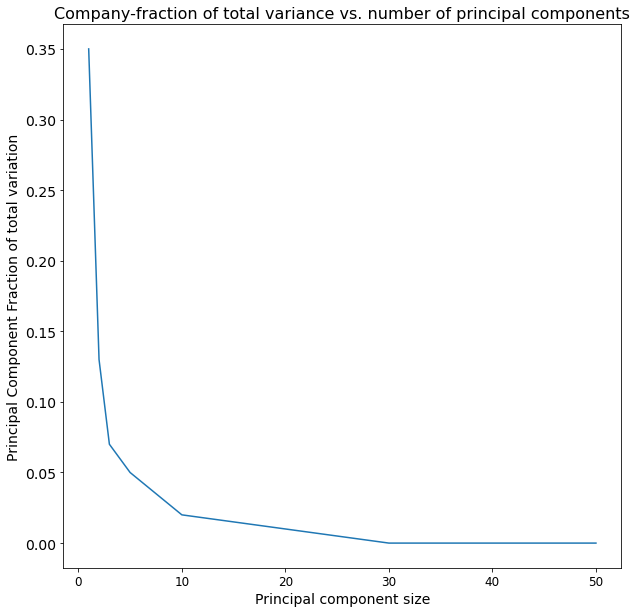

In [197]:
# Perform PCA of country dataset
Country_train_df = X_train.filter(regex='^country',axis=1).fillna(0)
Country_test_df = X_test.filter(regex='^country',axis=1).fillna(0)

# create PCA features for train and test set
pca_Country = PCA()  
principalComponents_Country_train = pca_Country.fit_transform(Country_train_df)

# for each item in k, display the explained fraction of variation for first
# k principal components
# concat with train dataset
ratios = pca_Country.explained_variance_ratio_
k = [1,2,3,4,5,10,20,30,40,50]
fraction_list = []

for item in k:
  fraction_list.append(round(ratios[item-1],2))

# plot the graph
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylabel('Principal Component Fraction of total variation',fontsize=14)
plt.xlabel('Principal component size',fontsize=14)
plt.title('Company-fraction of total variance vs. number of principal components',
          fontsize=16)
plt.plot(k,fraction_list)




From the above graph, choosing number of components as 10 as it is showing the best variance vs size fit

In [198]:
# create PCA features for train and test set
n_cty_components=10
pca_Country = PCA(n_components=n_cty_components)  
principalComponents_Country_train = pca_Country.fit_transform(Country_train_df)
principalComponents_Country_test = pca_Country.transform(Country_test_df)

n_cty_components
# create dataframes from numpy
df_cty_train = pd.DataFrame(principalComponents_Country_train,columns=['Country_'+ str(x) for x in range(n_cty_components)])
df_cty_test = pd.DataFrame(principalComponents_Country_test,columns=['Country_'+ str(x) for x in range(n_cty_components)])

# drop country prefix columns
X_train = X_train.drop(list(X_train.filter(regex='^country_',axis=1).columns), axis=1)
X_test = X_test.drop(list(X_test.filter(regex='^country_',axis=1).columns), axis=1)

# concat with train dataset
X_train = pd.concat([X_train, df_cty_train],axis = 1)
X_test = pd.concat([X_test, df_cty_test],axis = 1)


#### Industry Dataset

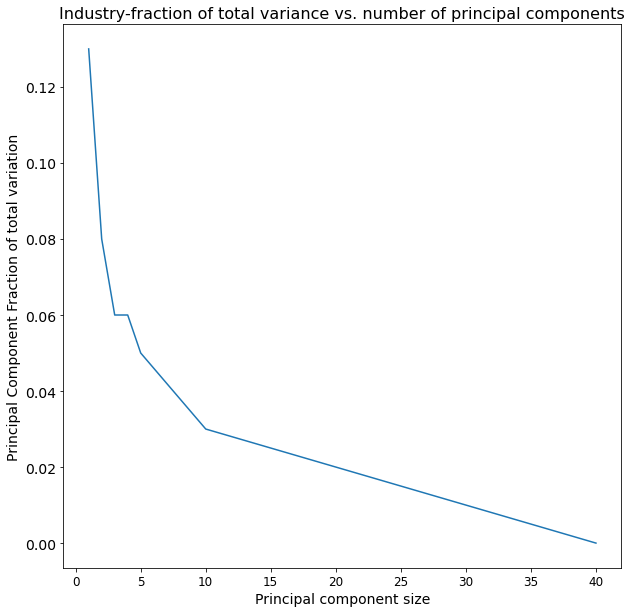

In [199]:
# Perform PCA of industry dataset
industry_train_df = X_train.filter(regex='^ind_',axis=1).fillna(0)
industry_test_df = X_test.filter(regex='^ind_',axis=1).fillna(0)

# create PCA features for train and test set
pca_Industry = PCA() 
principalComponents_Industry_train = pca_Industry.fit_transform(industry_train_df)

# for each item in k, display the explained fraction of variation for first
# k principal components
# concat with train dataset
ratios = pca_Industry.explained_variance_ratio_
k = [1,2,3,4,5,10,20,30,40]
fraction_list = []

for item in k:
  fraction_list.append(round(ratios[item-1],2))

# plot the graph
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.ylabel('Principal Component Fraction of total variation',fontsize=14)
plt.xlabel('Principal component size',fontsize=14)
plt.title('Industry-fraction of total variance vs. number of principal components',
          fontsize=16)
plt.plot(k,fraction_list)


From the above graph, choosing number of components as 10 as it is showing the best variance vs size fit

In [200]:
# create PCA features for train and test set
n_ind_components=10
pca_Industry = PCA(n_components=n_ind_components) 
principalComponents_Industry_train = pca_Industry.fit_transform(industry_train_df)
principalComponents_Industry_test = pca_Industry.transform(industry_test_df)

# create dataframes from numpy
df_ind_train = pd.DataFrame(principalComponents_Industry_train,columns=['Ind_'+ str(x) for x in range(n_ind_components)])
df_ind_test = pd.DataFrame(principalComponents_Industry_test,columns=['Ind_'+ str(x) for x in range(n_ind_components)])

# drop country prefix columns
X_train = X_train.drop(list(X_train.filter(regex='^ind_',axis=1).columns), axis=1)
X_test = X_test.drop(list(X_test.filter(regex='^ind_',axis=1).columns), axis=1)

# concat with train dataset
X_train = pd.concat([X_train, df_ind_train],axis = 1)
X_test = pd.concat([X_test, df_ind_test],axis = 1)

#### Visualizing PCA for Industry and Country datasets

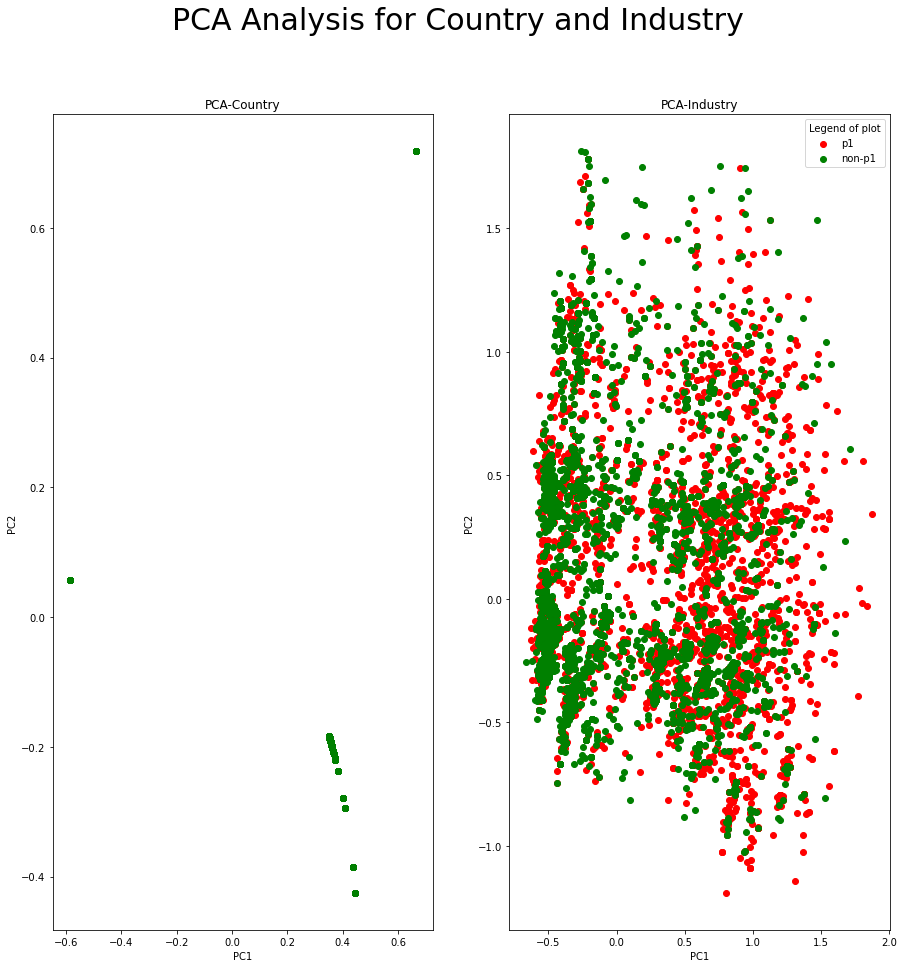

In [201]:
# create graphs for PCA analysis for country and industry features

Country_df = X.filter(regex='^country',axis=1).fillna(0)
pca_new_Country = PCA(n_components=10)  
Country_df_PCA = pca_new_Country.fit_transform(Country_df)

Industry_df = X.filter(regex='^ind_',axis=1).fillna(0)
pca_new_Industry_df = PCA(n_components=30)  
Industry_df_PCA = pca_new_Industry_df.fit_transform(Industry_df)

# The PCA model
fig, axes = plt.subplots(1,2,figsize=(15,15))
colors = ['r','g']
fig.suptitle('PCA Analysis for Country and Industry', fontsize=30)
targets = [1,0]
for target, color in zip(targets,colors):
  indexes = np.where(y == target)
  axes[0].scatter(Country_df_PCA[indexes][:,0], Country_df_PCA[indexes][:,1],color=color)
  axes[0].set_xlabel('PC1')
  axes[0].set_ylabel('PC2')
  axes[0].set_title('PCA-Country')
  axes[1].scatter(Industry_df_PCA[indexes][:,0], Industry_df_PCA[indexes][:,1], color=color)
  axes[1].set_xlabel('PC1')
  axes[1].set_ylabel('PC2')
  axes[1].set_title('PCA-Industry')
plt.axis('tight')

out_labels = ['p1','non-p1']
plt.legend(out_labels,prop={'size':10},loc='upper right',title='Legend of plot')

plt.show()

In [202]:
print("Final train dataset shape",X_train.shape)
print("\nFinal test dataset shape",X_test.shape)

print('\nTrain Dataframe Columns:\n\n{}'.format(X_train.columns.to_list()))

print('\nTest Dataframe Columns:\n\n{}'.format(X_test.columns.to_list()))


Final train dataset shape (12531, 36)

Final test dataset shape (3133, 36)

Train Dataframe Columns:

['kc_F', 'kc_F_S', 'kc_FR', 'kc_FR_S', 'triangle_count', 'out_degree', 'in_degree', 'total_degree', 'pr_F', 'pr_F_S', 'pr_FR', 'pr_FR_S', 'rank', 'employee_count_ord', 'total_funding_usd', 'age', 'Country_0', 'Country_1', 'Country_2', 'Country_3', 'Country_4', 'Country_5', 'Country_6', 'Country_7', 'Country_8', 'Country_9', 'Ind_0', 'Ind_1', 'Ind_2', 'Ind_3', 'Ind_4', 'Ind_5', 'Ind_6', 'Ind_7', 'Ind_8', 'Ind_9']

Test Dataframe Columns:

['kc_F', 'kc_F_S', 'kc_FR', 'kc_FR_S', 'triangle_count', 'out_degree', 'in_degree', 'total_degree', 'pr_F', 'pr_F_S', 'pr_FR', 'pr_FR_S', 'rank', 'employee_count_ord', 'total_funding_usd', 'age', 'Country_0', 'Country_1', 'Country_2', 'Country_3', 'Country_4', 'Country_5', 'Country_6', 'Country_7', 'Country_8', 'Country_9', 'Ind_0', 'Ind_1', 'Ind_2', 'Ind_3', 'Ind_4', 'Ind_5', 'Ind_6', 'Ind_7', 'Ind_8', 'Ind_9']


##Run through pipeline 
* Import GPU libraries for SVM and Xgboost
* Create parameters for experimentation and tuning inputs
* Use RandomizedSearchCV for pipeline
* Store result into a .json file

From: <a href='https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900'>An Easier Way to Encode Categorical Features</a>

Feature scaling :
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

In [207]:
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,export_graphviz
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler,StandardScaler,\
MaxAbsScaler,RobustScaler,QuantileTransformer,PowerTransformer
from libsvm.svmutil import *
from sklearn.decomposition import PCA

results = {}
classifier_list = []
LRR = LogisticRegression(max_iter=10000, tol=0.1)
KNN = KNeighborsClassifier(n_neighbors=5)
BNB = BernoulliNB()
GNB = GaussianNB()
SVM = svm.SVC()
DCT = DecisionTreeClassifier()
XGB = xgb.XGBRegressor() #tree_method='gpu_hist', gpu_id=0
RMF = RandomForestClassifier()

#classifier
classifier_list.append(('LRR', LRR, {'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000]}))
classifier_list.append(('KNN', KNN, {}))
classifier_list.append(('BNB', BNB, {'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}))
classifier_list.append(('GNB', GNB, {'classifier__var_smoothing': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]}))
classifier_list.append(('DCT', DCT, {'classifier__max_depth':np.arange(1, 21),
                                    'classifier__min_samples_leaf':[1, 5, 10, 20, 50, 100]}))
classifier_list.append(('XGB', XGB, {}))
classifier_list.append(('RMF', RMF, {}))
classifier_list.append(('SVM', SVM, {}))

encoder_list = [ce.one_hot.OneHotEncoder]
scaler_list = [StandardScaler()]

for label, classifier, params in classifier_list:
    results[label] = {}
    for encoder in encoder_list:
        for feature_scaler in scaler_list:
            results[label][f'{encoder.__name__} with {feature_scaler}'] = {}
            print('{} with {} and {}'.format(label,encoder.__name__,feature_scaler))

            numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

            categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                                      ('woe', encoder())])

            preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                           ('cat', categorical_transformer, categorical_features)])

            pipe = Pipeline(steps=[#('preprocessor', preprocessor),
                                   ('scaler', feature_scaler),
                                   ('classifier', classifier)])

            if params != {}:
                search = RandomizedSearchCV(pipe, params, n_jobs=-1)
                search.fit(X_train, y_train)
                print('Best parameter (CV score={:.3f}): {}'.format(search.best_score_, search.best_params_))
                model = search.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                if label == 'XGB':
                    y_pred = [round(value) for value in y_pred]
                score = f1_score(y_test, y_pred,average='weighted')
                print('Best score: {:.4f}\n'.format(score))
                results[label][f'{encoder.__name__} with {feature_scaler}']['score'] = score
                try:
                    results[label][f'{encoder.__name__} with {feature_scaler}']['best_params'] = search.best_params_
                except:
                    print('Something went wrong w/ GridSearch or pipeline fitting.')
            else:
                try:
                    model = pipe.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    if label == 'XGB':
                        y_pred = [round(value) for value in y_pred]
                    score = f1_score(y_test, y_pred,average='weighted')
                    print('Score: {:.4f}\n'.format(score))
                    results[label][f'{encoder.__name__} with {feature_scaler}']['score'] = score
                except:
                    print('Something went wrong with pipeline fitting')

# encode to encode int/float and array types and write the output json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

# File is saved under Files directory. /content would be the baseline folder
# You can click on folder icon on left side of the directory structure to
# see the created file

json.dumps(results, cls=NpEncoder)
with open('files/output/results_baseline.json', 'w') as fp:
    json.dump(results, fp, sort_keys=True, indent=4, cls=NpEncoder)
with open('files/output/results_baseline.json', 'r') as fp:
    results = json.load(fp)
    
print(results)

LRR with OneHotEncoder and StandardScaler()
Best parameter (CV score=0.784): {'classifier__C': 1000}
Best score: 0.7718

KNN with OneHotEncoder and StandardScaler()
Score: 0.7624

BNB with OneHotEncoder and StandardScaler()
Best parameter (CV score=0.747): {'classifier__alpha': 0.0001}
Best score: 0.7159

GNB with OneHotEncoder and StandardScaler()
Best parameter (CV score=0.747): {'classifier__var_smoothing': 0.0001}
Best score: 0.7141

DCT with OneHotEncoder and StandardScaler()
Best parameter (CV score=0.813): {'classifier__min_samples_leaf': 100, 'classifier__max_depth': 7}
Best score: 0.7984

XGB with OneHotEncoder and StandardScaler()
Score: 0.8241

RMF with OneHotEncoder and StandardScaler()
Score: 0.8169

SVM with OneHotEncoder and StandardScaler()
Score: 0.7808

{'BNB': {'OneHotEncoder with StandardScaler()': {'best_params': {'classifier__alpha': 0.0001}, 'score': 0.7158953889968329}}, 'DCT': {'OneHotEncoder with StandardScaler()': {'best_params': {'classifier__max_depth': 5, 